# Classification Workflow with Pipelines

In [3]:
!pip install imblearn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/92/e8/86c36e1b13007ca9c89381adac6c078cfc8fb71841a76c08a3fe3eca91d3/imbalanced_learn-0.12.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 6.2 MB/s eta 0:00:0000:01


Let's add pipelines into our workflow!

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [5]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `FunctionTransformer`

Let's try a very simple pipeline first.

In [7]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int'])

In [8]:
# The FunctionTransformer will turn my function
# into a transformer.

GrabNumeric = FunctionTransformer(grab_numeric)

In [9]:
pipe = Pipeline(steps=[('num', GrabNumeric),
                       ('ss', StandardScaler())])

In [10]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x167abf1f0>)),
                ('ss', StandardScaler())])

In [11]:
pipe.transform(X_train)

array([[-1.62051704,         nan, -0.46765956, -0.46887833, -0.0325683 ],
       [ 0.80934914, -0.30465857, -0.46765956, -0.46887833, -0.48733085],
       [-0.40558395, -0.3735649 , -0.46765956,  2.04687047, -0.34285405],
       ...,
       [ 0.80934914,  0.79784282,  1.22097065, -0.46887833, -0.35045024],
       [-1.62051704, -1.06262827,  0.37665554,  2.04687047,  1.7030926 ],
       [-1.62051704, -0.58028391, -0.46765956,  0.78899607,  0.8747751 ]])

That looks like it worked!

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [12]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [14]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [2, 3, 4, 6]),
                                         ('subpipe_cat', subpipe_cat, [0, 1, 5, 7, 8])],
                           remainder='passthrough')

In [15]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.

logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', LogisticRegression(random_state=42))])

In [16]:
logreg_model_pipe.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [0, 1, 5, 7, 8])])),
                ('logreg', LogisticRegression(random_state=42))])

In [17]:
logreg_model_pipe.score(X_train, y_train)

0.8922155688622755

## Bringing in Our Modeling Class from before

In [50]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [19]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/

/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_33767/2953851690.py:55: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.4`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(y=self.cv_results, ax=ax, bw=.4)


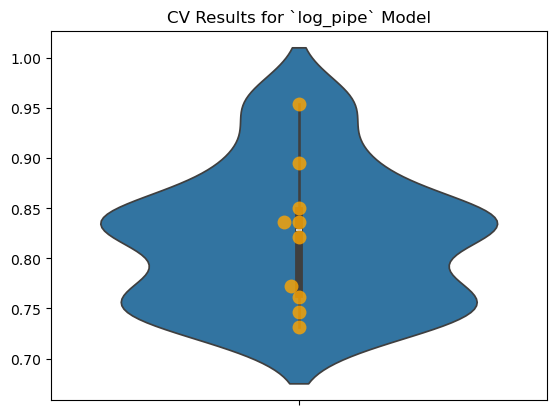

In [20]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax);

## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [21]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [22]:
rfc_model_pipe.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [0, 1, 5, 7, 8])])),
                ('rfc', RandomForestClassifier(random_state=42))])

In [23]:
rfc_model_pipe.score(X_train, y_train)

0.9985029940119761

In [24]:
forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/

/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_33767/2953851690.py:55: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.4`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(y=self.cv_results, ax=ax, bw=.4)


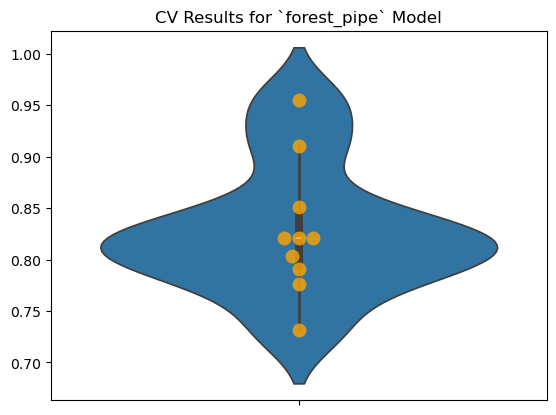

In [25]:
fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

### Gradient Booster

In [26]:
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

In [27]:
gbc_model_pipe.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [0, 1, 5, 7, 8])])),
                ('gbc', GradientBoostingClassifier(random_state=42))])

In [28]:
gbc_model_pipe.score(X_train, y_train)

0.8622754491017964

In [29]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/

/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_33767/2953851690.py:55: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.4`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(y=self.cv_results, ax=ax, bw=.4)


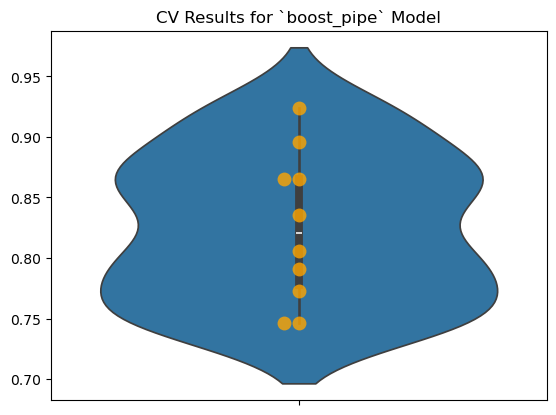

In [30]:
fig, ax = plt.subplots()

boost_pipe.plot_cv(ax=ax);

## Tuning and Cross-Validating

In [31]:
params = {}
params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [1, 5, 10]

gs = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=params,
                 cv=10)

In [32]:
gs.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         [0, 1,
                                                                          5, 7,
                                                                          8])])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__min_samples_leaf': [1, 5, 10]})

In [33]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1}

In [34]:
# Mean test score for each of six models

gs.cv_results_['mean_test_score']

array([0.82799638, 0.6272275 , 0.62424242, 0.81906377, 0.6272275 ,
       0.62424242])

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [35]:
y_train.value_counts()

Survived
0    415
1    253
Name: count, dtype: int64

In [36]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [37]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [38]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [39]:
y_train_clean.value_counts()

Survived
0    317
1    219
Name: count, dtype: int64

In [40]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

Survived
0    317
1    317
Name: count, dtype: int64

In [41]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

Survived
0    317
1    253
Name: count, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [42]:
imb_pipe = ImPipeline(steps=[('ct', CT),
                             ('sm', SMOTE(random_state=42)),
                            ('rfc', RandomForestClassifier(random_state=42))])

In [43]:
imb_pipe.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [2, 3, 4, 6]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [0, 1, 5, 7, 8])])),
                ('sm', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [44]:
imb_pipe.score(X_train, y_train)

0.9985029940119761

### Gridsearching

In [45]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 5, 10],
          'sm__k_neighbors': [3, 5, 9]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10)

In [46]:
gs.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [2, 3,
                                                                          4,
                                                                          6]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         [0, 1,
                                                                          5, 7,
                                                                          8])])),
                                       ('sm', SMOTE(random_state=42)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__min_samples_leaf': [1, 5, 10],
                         'sm__k_neighbors': [3, 5, 9]})

In [47]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 3}

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [48]:
final_model = imb_pipe

In [49]:
plot_confusion_matrix(final_model, X_test, y_test);

NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
y_hat = final_model.predict(X_test)

In [ ]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")

## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






